# Room Graph

In [1]:
# Load dependencies
import os
import numpy as np 
import pandas as pd 
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import networkx as nx

In [2]:
# Plot style configuration
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] ='w'
plt.rcParams['axes.edgecolor'] = '#D6D6D6'
plt.rcParams['axes.linewidth'] = 2

## SHL Architects Studio Malmö

![dfgfdg](data/SHL-Architects_Studio-Malmö.jpg)

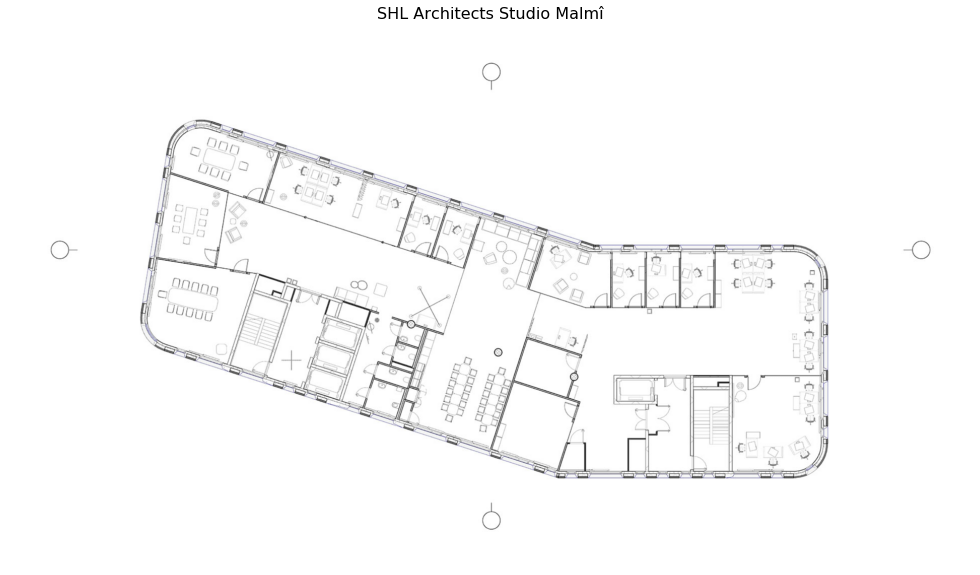

In [7]:
#Source: 
img=mpimg.imread('data/layout.jpg')
fig = plt.figure(figsize = (30,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, interpolation='bilinear')
ax.axis('off')
ax.set_title('SHL Architects Studio Malmî', fontsize=16);

## Get structured data

In [ ]:
# Load data 
rooms = pd.read_csv('data/room_schedule.csv', skiprows=[2], keep_default_na=False)
rooms.columns = rooms.iloc[0]
rooms.drop([0], inplace=True)
rooms['Area'] = rooms['Area'].map(lambda x: x.rstrip(' m²'))
rooms

In [ ]:
# Load data 
doors = pd.read_csv('data/door_schedule.csv', skiprows=[2], keep_default_na=False)
doors.columns = doors.iloc[0]
doors.drop([0], inplace=True)

In [ ]:
doors['From Room: Number'][:-1] = doors['From Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])
doors['To Room: Number'][:-1] = doors['To Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])

In [ ]:
doors = doors.rename(columns={'From Room: Number': 'From Room', 'To Room: Number': 'To Room', 'Rough Width': 'Width', 'Rough Height': 'Height'})
doors

## Preprocessing

In [ ]:
def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)
    
    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)
    
    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)
    
    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

In [ ]:
def calculateCovariance(X):
    meanX = np.mean(X, axis = 0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance

In [ ]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

In [ ]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

In [ ]:
def whiten(X):
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

### Preprocessing rooms

In [ ]:
ra = np.array(rooms['Area']).astype(float)
rp = np.array(rooms['Perimeter']).astype(int)

In [ ]:
R = np.array([ra, rp]).T
R.shape

In [ ]:
plotDataAndCov(R)
plt.show()
plt.close()

In [ ]:
R = whiten(standardize(center(R)))
plotDataAndCov(R)
plt.show()
plt.close()

### Preprocessing doors

In [ ]:
dw = np.array(doors['Width'][:-1]).astype(int)
dh = np.array(doors['Height'][:-1]).astype(int)

In [ ]:
# Calculate normalized area of door openings
bond = dw*dh
bond = bond/bond.max()

In [ ]:
B = np.array([dw, dh]).T
B.shape

In [ ]:
plotDataAndCov(B)
plt.show()
plt.close()

In [ ]:
B = whiten(standardize(center(B)))
plotDataAndCov(B)
plt.show()
plt.close()

## Graph construction

In [ ]:
fr = np.array(doors['From Room'][:-1])
to = np.array(doors['To Room'][:-1])

In [ ]:
pairs = np.vstack((fr, to)).T
pairs

In [ ]:
import warnings
warnings.filterwarnings("ignore")
 
# Create a networkx graph object
G = nx.MultiGraph() 
 
# Add edges to to the graph object
# Each tuple represents an edge between two nodes
G.add_edges_from(pairs[:, [0, 1]])
c = np.array(G.edges).T[2].astype(int)
my_pos = nx.spring_layout(G, seed = 56)
# Draw the resulting graph
nx.draw(G, pos=my_pos, with_labels=True, edge_color=c, width=1.5, node_size=4, edge_cmap=plt.cm.Paired)

In [ ]:
pairs = np.vstack((fr, to, c)).T
pairs

In [ ]:
G.nodes(data=True)

In [ ]:
G.edges(data=True,keys=True)

## Embed Attributes

In [ ]:
weight = 0
nx.set_edge_attributes(G, weight, 'weight')

In [ ]:
for i, pair in enumerate(pairs):
    G.edges[(pair[0], pair[1], pair[2])]['weight'] = bond[i]

In [ ]:
G.edges(data=True,keys=True)

In [ ]:
# create weighted graph from G
N = nx.Graph()
for u,v,data in G.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if N.has_edge(u,v):
        N[u][v]['weight'] += w
    else:
        N.add_edge(u, v, weight=w)

In [ ]:
N.edges(data=True)

In [ ]:
for i, node in enumerate(rooms['Name']):
    N.nodes[node]['area'] = ra[i]

In [ ]:
N.nodes.data()

In [ ]:
A = nx.to_numpy_matrix(N)
plt.figure(figsize=(15,8))
plt.title('Adjacency matrix')
sns.set()
sns.heatmap(A, cmap="YlGnBu", annot=True, xticklabels=N.nodes, yticklabels=N.nodes);

## Gephi Export

In [ ]:
with open("data/spectral_map.graphml", "wb") as ofile:
    nx.write_graphml(N, ofile)

## Get data laboratory results

In [ ]:
# Load data 
data = pd.read_csv('data/data_lab.csv')
data = data.rename(columns={'d0': 'area'})
columns = ['Id', 'timeset', 'componentnumber']
data.drop(columns, inplace=True, axis=1)
data

In [ ]:
labels = np.array(data['Label'])

In [ ]:
final_data = np.array(data.drop(['Label'], axis=1))

In [ ]:
X = final_data
X.shape

In [ ]:
from sklearn.manifold import Isomap

In [ ]:
# apply isomap with k = 24 and output dimension = 3
model = Isomap(n_components=3, n_neighbors=24)
proj = model.fit_transform(X)

In [ ]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] ='w'
plt.rcParams['axes.edgecolor'] = '#D6D6D6'
plt.rcParams['axes.linewidth'] = 2

In [ ]:
# plot the isomap projection
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj[:, 0], proj[:, 1], c="#0A98BE", s=140, lw=0, alpha=1);
# Remove the top and right axes from the data plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=7, random_state=13)
Kmean.fit(proj)

In [ ]:
clusters = Kmean.labels_

In [ ]:
match = np.vstack((labels, clusters)).T
print(match)

In [ ]:
cl=["#d1cbb6", "#9cdbd9", "#60afd6", "#e1d555", "#8ba6b2", "#9cb997", "#d1e0d7"]

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
cmap = ListedColormap(cl)

In [ ]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] ='w'
plt.rcParams['axes.edgecolor'] = '#D6D6D6'
plt.rcParams['axes.linewidth'] = 2

In [ ]:
# plot the isomap projection
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj[:, 0], proj[:, 1], cmap=cmap, c=clusters, s=140, lw=0, alpha=1);
# Remove the top and right axes from the data plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i, m in enumerate(match):
    ax.text(proj[i, 0]+0.07, proj[i, 1]+0.07, m[-1], fontsize=12)

In [ ]:
img = mpimg.imread('data/layout_clustered.jpg')
fig = plt.figure(figsize = (30,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, interpolation="bilinear")
ax.axis('off')
ax.set_title('Clustered Studio Malmî', fontsize=16);

In [ ]:
img = mpimg.imread('data/Graph_clustered.png')
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, interpolation="bilinear")
ax.axis('off')
ax.set_title('Clustered Studio Malmî Graph', fontsize=16);